In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
import sys
from DispFormer.dataloader import *
from DispFormer.plots import *
from DispFormer.model.dispformer import *
from DispFormer.utils import *
from torch.utils.data import Dataset, DataLoader, ConcatDataset, SubsetRandomSampler
import torch.nn as nn
from torch import optim
from tqdm import tqdm

# load the colormap from GMT
cpt_file = "./DispFormer/plot_source/GMT_panoply.cpt"
cmap = load_cpt(cpt_file,num_colors=20,reverse=True)


device = "cuda:0"
# Configuration settings
settings = {
    'training': {
        'batch_size'    : 256,
        'num_workers'   : 10  # Number of workers for DataLoader
    }
}

######################################################
#                  Training Datasets
######################################################
# Paths for input data and saving the model
syn_data_path            = "./Script/ModelDesign/datasets/CSRM/syn_period_phase_group.npz"
real_data_path           = "./Script/ModelDesign/datasets/CSRM/obs_period_phase_group.npz"

syn_label_path           = "./Script/ModelDesign/datasets/CSRM/depth_vs.npz"
real_label_path          = "./Script/ModelDesign/datasets/CSRM/obs_depth_vs.npz"

train_data_path          = "./Script/ModelDesign/datasets/CSRM/train_valid_split/train_data/period_phase_group.npz"
train_label_path         = "./Script/ModelDesign/datasets/CSRM/train_valid_split/train_data/depth_vs.npz"

valid_data_path          = "./Script/ModelDesign/datasets/CSRM/train_valid_split/valid_data/period_phase_group.npz"
valid_label_path         = "./Script/ModelDesign/datasets/CSRM/train_valid_split/valid_data/depth_vs.npz"

syn_dataset = DispersionDatasets(
    input_data_path=syn_data_path,
    input_label_path=syn_label_path,
    train=True,
    interp_layer=True,
    layer_thickness=0.5,
    layer_number=400,
    layer_used_range=[0, 400],
    augmentation_train_data=False,
    num_workers=settings['training']['num_workers']
)

real_dataset = DispersionDatasets(
    input_data_path=real_data_path,
    input_label_path=real_label_path,
    train=True,
    interp_layer=True,
    layer_thickness=0.5,
    layer_number=400,
    layer_used_range=[0, 400],
    augmentation_train_data=False,
    num_workers=settings['training']['num_workers']
)

train_dataset = DispersionDatasets(
    input_data_path=train_data_path,
    input_label_path=train_label_path,
    train=True,
    interp_layer=True,
    layer_thickness=0.5,
    layer_number=400,
    layer_used_range=[0, 400],
    augmentation_train_data=False,
    num_workers=settings['training']['num_workers']
)

valid_dataset = DispersionDatasets(
    input_data_path=valid_data_path,
    input_label_path=valid_label_path,
    train=True,
    interp_layer=True,
    layer_thickness=0.5,
    layer_number=400,
    layer_used_range=[0, 400],
    augmentation_train_data=False,
    num_workers=settings['training']['num_workers']
)

collect_fn = train_collate_fn

syn_loader = DataLoader(
    syn_dataset,
    batch_size  = settings['training']['batch_size'],
    shuffle     = False,
    collate_fn  = collect_fn,
    num_workers = settings['training']['num_workers']
)
real_loader = DataLoader(
    real_dataset,
    batch_size  = settings['training']['batch_size'],
    shuffle     = False,
    collate_fn  = collect_fn,
    num_workers = settings['training']['num_workers']
)

train_loader = DataLoader(
    train_dataset,
    batch_size  = settings['training']['batch_size'],
    shuffle     = False,
    collate_fn  = collect_fn,
    num_workers = settings['training']['num_workers']
)

valid_loader = DataLoader(
    valid_dataset,
    batch_size  = settings['training']['batch_size'],
    shuffle     = False,
    collate_fn  = collect_fn,
    num_workers = settings['training']['num_workers']
)

plot_base_path = "Script/ModelDesign/test-few-shot/Figures/"

syn_dataset.__len__(),real_dataset.__len__()

(12705, 12705)

In [2]:
all_disp_loc_path  = "./Script/ModelDesign/datasets/CSRM/depth_vs_loc.npz"
all_target_vs_path = "./Script/ModelDesign/datasets/CSRM/depth_vs.npz"
all_disp_loc       = np.load(all_disp_loc_path)["data"]
all_target_vs      = np.load(all_target_vs_path)["data"]

train_disp_loc_path  = "./Script/ModelDesign/datasets/CSRM/train_valid_split/train_data/depth_vs_loc.npz"
train_target_vs_path = "./Script/ModelDesign/datasets/CSRM/train_valid_split/train_data/depth_vs.npz"
train_disp_loc  = np.load(train_disp_loc_path)["data"]
train_target_vs = np.load(train_target_vs_path)["data"] 


In [3]:
# functions for forward modeling and figuring
def gen_init_model(t,cg_obs,thick,area=False):
    """
    generate the initial model based on empirical formula 
    developed by Thomas M.Brocher (2005).
    ---------------------
    Input Parameters:
        t : 1D numpy array 
            => period of observaton dispersion points
        cg_obs: 1D numpy array 
            => phase velocity of observation dispersion points
        thick : 1D numpy array 
            => thickness of each layer
    Output: the initialize model
        thick : 1D numpy array 
            => thickness
        vs : 1D numpy array 
            => the shear wave velocity
        vp : 1D numpy array 
            => the compress wave velocity
        rho: 1D numpy array 
            => the density
    --------------------
    Output parameters:
        model:Dict 
            => the generated model
    """
    wavelength  = t*cg_obs
    nlayer      = len(thick)
    lambda2L    = 0.65      # the depth faction 0.63L
    beta        = 0.92      # the poisson's ratio
    eqv_lambda = lambda2L*wavelength
    
    lay_model = np.zeros((nlayer,2))
    lay_model[:,0] = thick
    for i in range(nlayer-1):
        if i == 0:
            up_bound = 0
        else:
            up_bound = up_bound + lay_model[i-1,0]  # the top-layer's depth
        low_bound = up_bound + lay_model[i,0]       # the botton-layer's depth
        # vs for every layer
        lambda_idx = np.argwhere((eqv_lambda>up_bound) & (eqv_lambda<low_bound))
        if len(lambda_idx)>0:
            lay_model[i,1] = np.max(cg_obs[lambda_idx])/beta # phase velocity -> vs
        else:
            lambda_idx = np.argmin(np.abs(eqv_lambda - low_bound))
            lay_model[i,1] = cg_obs[lambda_idx]/beta
    # set the last layer
    lay_model[nlayer-1,0] = 0
    lay_model[nlayer-1,1] = np.max(cg_obs)*1.1
    thick = lay_model[:,0]
    vs = lay_model[:,1]
    vp = 0.9409 + 2.0947*vs - 0.8206*vs**2+ 0.2683*vs**3 - 0.0251*vs**4
    depth = np.cumsum(thick)
    
    mask = depth>120
    vp[mask] = vs[mask]*1.79
    rho = 1.6612*vp - 0.4721*vp**2 + 0.0671*vp**3 - 0.0043*vp**4 + 0.000106*vp**5
    
    model = {
        "thick":thick,
        "vp":vp,
        "vs":vs,
        "rho":rho
    }
    if area:
        return thick,vp,vs,rho 
    else:
        return model
    
def plot_single_station_cmp_res(disp_loc,inputs_disp,target_vs,Transformer_inv_vs,
                                sta_idx,depth_idx,
                                save_path="",show=True):
    ############################################################
    plt.figure(figsize=(12,10))
    plt.subplot(221)
    # Scatter plot for target values
    plt.scatter(disp_loc[:,0],disp_loc[:,1],c=target_vs[:, 1, depth_idx]*1000, s=10, cmap="jet_r", edgecolor='k', linewidth=0.1)
    plt.scatter(disp_loc[sta_idx,0],disp_loc[sta_idx,1],s=60,facecolor=None,edgecolor='k',marker='v',label='select station')
    # plt.scatter(train_disp_loc[::sparse_num,0],train_disp_loc[::sparse_num,1],s=2,c='k',marker='.',label='training sets')
    plt.legend(fontsize =11,loc='upper left')
    # plt.title(f"depth:{depth_idx*0.5} km")
    plt.xlabel("Longitude", fontsize=12)
    plt.ylabel("Latitude", fontsize=12)
    plt.tick_params(labelsize=12)
    plt.axis("equal")

    ############################################################
    mask = (inputs_disp[sta_idx,1,:]>0) + (inputs_disp[sta_idx,2,:]>0)
    t = inputs_disp[sta_idx,0,mask]
    # generated initial model
    phase_mask  = inputs_disp[sta_idx,1,:]>0
    phase_obs   = inputs_disp[sta_idx,1,:][phase_mask]
    thickness   = np.arange(target_vs[sta_idx,1,:].shape[0])*0.5
    # init_thick,init_vp,init_vs,init_rho = gen_init_model(inputs_disp[sta_idx,0,phase_mask],phase_obs,thickness,area=True) 
    
    plt.subplot(222)
    plt.step(target_vs[sta_idx,1,:],target_vs[sta_idx,0,:]          ,where='post',c='k',linestyle='--',label="True")
    # plt.step(init_vs,target_vs[sta_idx,0,:]          ,where='post',c='g',linestyle='-' ,label="Empirical")
    plt.step(Transformer_inv_vs[sta_idx,:],target_vs[sta_idx,0,:]   ,where='post',c='b',linestyle='-' ,label="Transformer")
    plt.legend(fontsize =12)
    plt.gca().invert_yaxis()
    plt.xlabel("S-wave velocity (km/s)", fontsize=12)
    plt.ylabel("Depth (km)", fontsize=12)
    plt.tick_params(labelsize=12)
    plt.grid()

    ###########################################################
    Transformer_depth,Transformer_vs = np.arange(Transformer_inv_vs.shape[1])*0.5,Transformer_inv_vs[sta_idx]
    Transformer_thickness,Transformer_vp,Transformer_vs,Transformer_rho= gen_model(depth=Transformer_depth,vs=Transformer_vs,area=True)
    Transformer_vel_model = np.hstack((Transformer_thickness.reshape(-1,1),Transformer_vp.reshape(-1,1),Transformer_vs.reshape(-1,1),Transformer_rho.reshape(-1,1)))
    Transformer_pd = PhaseDispersion(*Transformer_vel_model.T)
    Transformer_gd = GroupDispersion(*Transformer_vel_model.T)
    Transformer_phase_disp = [Transformer_pd(t, mode=i, wave="rayleigh") for i in range(1)]
    Transformer_group_disp = [Transformer_gd(t, mode=i, wave='rayleigh') for i in range(1)]
    
    # Initial_vel_model = np.hstack((init_thick.reshape(-1,1),init_vp.reshape(-1,1),init_vs.reshape(-1,1),init_rho.reshape(-1,1)))
    # Initial_pd = PhaseDispersion(*Initial_vel_model.T)
    # Initial_gd = GroupDispersion(*Initial_vel_model.T)
    # Initial_phase_disp = [Initial_pd(t, mode=i, wave="rayleigh") for i in range(1)]
    # Initial_group_disp = [Initial_gd(t, mode=i, wave='rayleigh') for i in range(1)]

    plt.subplot(223)
    mask = inputs_disp[sta_idx,1,:]>0
    plt.scatter(inputs_disp[sta_idx,0,mask],inputs_disp[sta_idx,1,mask]             ,c='k',s=30,label='observed')
    # plt.scatter(Initial_phase_disp[0].period,Initial_phase_disp[0].velocity         ,c='g',s=10,label='Empirical')
    plt.scatter(Transformer_phase_disp[0].period,Transformer_phase_disp[0].velocity ,c='b',s=10,label='Transformer')
    # plt.legend()
    plt.xlabel("Period (s)", fontsize=12)
    plt.ylabel("Phase velocity (km/s)", fontsize=12)
    plt.tick_params(labelsize=12)

    plt.subplot(224)
    mask = inputs_disp[sta_idx,2,:]>0
    plt.scatter(inputs_disp[sta_idx,0,mask],inputs_disp[sta_idx,2,mask]             ,c='k',s=30,label='observed')
    # plt.scatter(Initial_group_disp[0].period,Initial_group_disp[0].velocity         ,c='g',s=10,label="Empirical")
    plt.scatter(Transformer_group_disp[0].period,Transformer_group_disp[0].velocity ,c='b',s=10,label="Transformer")
    # plt.legend()
    plt.xlabel("Period (s)", fontsize=12)
    plt.ylabel("Group velocity (km/s)", fontsize=12)
    plt.tick_params(labelsize=12)
    
    if not save_path == "":
        plt.savefig(save_path,bbox_inches='tight',dpi=300)
    
    if show == True:
        plt.show()
    else:
        plt.close()

def plot_slice_comparation(depth,all_disp_loc,target_vs,inv_vs,cmap='jet_r',figsize=(12,4)):
    # Set font style and size
    plt.rcParams['font.family'] = 'Arial'  # Font family
    plt.rcParams['font.size'] = 12  # Font size

    fig, ax = plt.subplots(1, 3, figsize=figsize)  # Increase figure size

    # Determine color limits for the first two scatter plots
    vmin = min(np.min(target_vs[:, 1, depth]), np.min(inv_vs[:, depth]))*1000
    vmax = max(np.max(target_vs[:, 1, depth]), np.max(inv_vs[:, depth]))*1000

    # Scatter plot for target values
    scatter1 = ax[0].scatter(all_disp_loc[:, 0], all_disp_loc[:, 1], c=target_vs[:, 1, depth]*1000, s=10, cmap=cmap, edgecolor='k', linewidth=0.1, vmin=vmin, vmax=vmax)
    ax[0].set_title("Target", fontsize=14, fontweight='bold')
    ax[0].set_xlabel("Longitude", fontsize=14)
    ax[0].set_ylabel("Latitude", fontsize=16)
    # ax[0].set_aspect('equal')  # Set equal aspect ratio

    # Scatter plot for inverted values
    scatter2 = ax[1].scatter(all_disp_loc[:, 0], all_disp_loc[:, 1], c=inv_vs[:, depth]*1000, s=10, cmap=cmap, edgecolor='k', linewidth=0.1, vmin=vmin, vmax=vmax)
    ax[1].set_title("Inverted", fontsize=14, fontweight='bold')
    ax[1].set_xlabel("Longitude", fontsize=14)
    ax[1].set_yticks([])
    # ax[1].set_aspect('equal')  # Set equal aspect ratio

    # Scatter plot for differences
    scatter3 = ax[2].scatter(all_disp_loc[:, 0], all_disp_loc[:, 1], c=np.abs(inv_vs[:, depth] - target_vs[:, 1, depth])*1000, s=10, cmap='gray_r', edgecolor='k', linewidth=0.1)
    ax[2].set_title("Difference", fontsize=14, fontweight='bold')
    ax[2].set_xlabel("Longitude", fontsize=14)
    ax[2].set_yticks([])
    # ax[2].set_aspect('equal')  # Set equal aspect ratio

    # Create horizontal colorbars with adjusted length
    cbar1 = fig.colorbar(scatter1, ax=ax[0], orientation='horizontal', pad=0.2, label='Vs (m/s)'           , shrink=1)  # Adjust shrink
    cbar2 = fig.colorbar(scatter2, ax=ax[1], orientation='horizontal', pad=0.2, label='Vs (m/s)'           , shrink=1)  # Adjust shrink
    cbar3 = fig.colorbar(scatter3, ax=ax[2], orientation='horizontal', pad=0.2, label='Vs Difference (m/s)', shrink=1)  # Adjust shrink

    # plt.tight_layout()  # Automatically adjust subplots to fit
    plt.subplots_adjust(wspace = 0.01)
    plt.show()

## prediction & calculate the misfits


In [4]:
depth_begin = 0
depth_end   = 240
criterion   = NMSE

######################################################
#                       Model
######################################################
# Configuration settings
settings = {
    'model': {
        'model_dim' : 128,
        'num_heads' : 8,
        'num_layers': 3,
        'output_dim': 400
    },
}

model  = DispersionTransformer(
                    settings['model']['model_dim'],
                    settings['model']['num_heads'],
                    settings['model']['num_layers'],
                    settings['model']['output_dim'],
                    device=device
                ).to(device)

zeroshot_model_path   = "Script/ModelDesign/pre-training/model/transformer_augdata.pt"
fewshot100_model_path = "Script/ModelDesign/fine-tuning/CSRM/model/transformer_sparse100.pt"
fewshot300_model_path = "Script/ModelDesign/fine-tuning/CSRM/model/transformer_sparse300.pt"

zeroshot_loaded_model       = load_model(model, zeroshot_model_path, device=device).to(device)
target_vs, inv_vs_zeroshot, inputs_disp = predict_res_transformer(zeroshot_loaded_model, criterion, real_loader, device=device)

fewshot100_loaded_model       = load_model(model, fewshot100_model_path, device=device).to(device)
_, inv_vs_fewshot100, _ = predict_res_transformer(fewshot100_loaded_model, criterion, real_loader, device=device)

fewshot300_loaded_model       = load_model(model, fewshot300_model_path, device=device).to(device)
_, inv_vs_fewshot300, _ = predict_res_transformer(fewshot300_loaded_model, criterion, real_loader, device=device)

/ailab/group/groups/ai4earth/liufeng1/.conda/envs/ADinversion/lib/python3.8/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [5]:
nmse_value  = NMSE_np(inv_vs_zeroshot[:,depth_begin:depth_end], target_vs[:, 1, depth_begin:depth_end])
mse_value   = MSE_np( inv_vs_zeroshot[:,depth_begin:depth_end], target_vs[:, 1, depth_begin:depth_end])
mae_value   = MAE_np( inv_vs_zeroshot[:,depth_begin:depth_end], target_vs[:, 1, depth_begin:depth_end])
nape_value  = MAPE_np(inv_vs_zeroshot[:,depth_begin:depth_end], target_vs[:, 1, depth_begin:depth_end])
mae_value,nmse_value

(125.2174824476242, 12348.042)

In [6]:
nmse_value  = NMSE_np(inv_vs_fewshot300[:,depth_begin:depth_end], target_vs[:, 1, depth_begin:depth_end])
mse_value   = MSE_np( inv_vs_fewshot300[:,depth_begin:depth_end], target_vs[:, 1, depth_begin:depth_end])
mae_value   = MAE_np( inv_vs_fewshot300[:,depth_begin:depth_end], target_vs[:, 1, depth_begin:depth_end])
nape_value  = MAPE_np(inv_vs_fewshot300[:,depth_begin:depth_end], target_vs[:, 1, depth_begin:depth_end])
mae_value,nmse_value

(79.4224739074707, 3118.2979)

In [7]:
nmse_value  = NMSE_np(inv_vs_fewshot100[:,depth_begin:depth_end], target_vs[:, 1, depth_begin:depth_end])
mse_value   = MSE_np( inv_vs_fewshot100[:,depth_begin:depth_end], target_vs[:, 1, depth_begin:depth_end])
mae_value   = MAE_np( inv_vs_fewshot100[:,depth_begin:depth_end], target_vs[:, 1, depth_begin:depth_end])
nape_value  = MAPE_np(inv_vs_fewshot100[:,depth_begin:depth_end], target_vs[:, 1, depth_begin:depth_end])
mae_value,nmse_value

(75.37244260311127, 2810.7378)

## Calculate the Data residule

In [8]:
from p_tqdm import p_map

In [9]:
# reference model
def calculate_dispersion(i):
    depth = np.arange(240)*0.5
    vs    = target_vs[i,1,:len(depth)]
    thickness,vp,vs,rho= gen_model(depth=depth,vs=vs,area=True)
    vel_model = np.hstack((thickness.reshape(-1,1),vp.reshape(-1,1),vs.reshape(-1,1),rho.reshape(-1,1)))
    # Periods must be sorted starting with low periods
    t = np.array([ 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 54, 58, 62, 66, 70])
    
    # Compute the 3 first Rayleigh- and Love- wave modal dispersion curves
    pd = PhaseDispersion(*vel_model.T)
    gd = GroupDispersion(*vel_model.T)
    phase_disp = pd(t, mode=0, wave="rayleigh")
    group_disp = gd(t, mode=0, wave='rayleigh')
    
    vel_model = np.hstack((depth.reshape(-1,1),vp.reshape(-1,1),vs.reshape(-1,1),rho.reshape(-1,1)))
    disp_data = np.hstack((t.reshape(-1,1),phase_disp.velocity.reshape(-1,1),group_disp.velocity.reshape(-1,1)))
    return disp_data,vel_model

if not os.path.exists("Script/ModelDesign/test-few-shot/datasets/ref_disp.npz"):
    pmap_out      = p_map(calculate_dispersion,np.arange(len(target_vs)))
    ref_disp_temp = np.array([pmap_out[i][0] for i in range(len(pmap_out))])
    ref_vel_temp  = np.array([pmap_out[i][1] for i in range(len(pmap_out))])
    np.savez("Script/ModelDesign/test-few-shot/datasets/ref_disp.npz",data=ref_disp_temp)
else:
    ref_disp_temp = np.load("Script/ModelDesign/test-few-shot/datasets/ref_disp.npz")["data"]

In [10]:
# zero shot
def calculate_dispersion(i):
    depth = np.arange(240)*0.5
    vs    = inv_vs_zeroshot[i,:len(depth)]
    thickness,vp,vs,rho= gen_model(depth=depth,vs=vs,area=True)
    vel_model = np.hstack((thickness.reshape(-1,1),vp.reshape(-1,1),vs.reshape(-1,1),rho.reshape(-1,1)))
    # Periods must be sorted starting with low periods
    t = np.array([ 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 54, 58, 62, 66, 70])
    
    # Compute the 3 first Rayleigh- and Love- wave modal dispersion curves
    pd = PhaseDispersion(*vel_model.T)
    gd = GroupDispersion(*vel_model.T)
    phase_disp = pd(t, mode=0, wave="rayleigh")
    group_disp = gd(t, mode=0, wave='rayleigh')
    
    vel_model = np.hstack((depth.reshape(-1,1),vp.reshape(-1,1),vs.reshape(-1,1),rho.reshape(-1,1)))
    disp_data = np.hstack((t.reshape(-1,1),phase_disp.velocity.reshape(-1,1),group_disp.velocity.reshape(-1,1)))
    return disp_data,vel_model
if not os.path.exists("Script/ModelDesign/test-few-shot/datasets/inv_disp_finetune_zeroshot.npz"):    
    pmap_out      = p_map(calculate_dispersion,np.arange(len(inv_vs_zeroshot)))
    inv_disp_temp = np.array([pmap_out[i][0] for i in range(len(pmap_out))])
    inv_vel_temp  = np.array([pmap_out[i][1] for i in range(len(pmap_out))])
    np.savez("Script/ModelDesign/test-few-shot/datasets/inv_disp_finetune_zeroshot.npz",data=inv_disp_temp)
else:
    inv_disp_temp = np.load("Script/ModelDesign/test-few-shot/datasets/inv_disp_finetune_zeroshot.npz")["data"]

In [11]:
# finetune model
def calculate_dispersion(i):
    depth = np.arange(240)*0.5
    vs    = inv_vs_fewshot100[i,:len(depth)]
    thickness,vp,vs,rho= gen_model(depth=depth,vs=vs,area=True)
    vel_model = np.hstack((thickness.reshape(-1,1),vp.reshape(-1,1),vs.reshape(-1,1),rho.reshape(-1,1)))
    # Periods must be sorted starting with low periods
    t = np.array([ 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 54, 58, 62, 66, 70])
    
    # Compute the 3 first Rayleigh- and Love- wave modal dispersion curves
    pd = PhaseDispersion(*vel_model.T)
    gd = GroupDispersion(*vel_model.T)
    phase_disp = pd(t, mode=0, wave="rayleigh")
    group_disp = gd(t, mode=0, wave='rayleigh')
    
    vel_model = np.hstack((depth.reshape(-1,1),vp.reshape(-1,1),vs.reshape(-1,1),rho.reshape(-1,1)))
    disp_data = np.hstack((t.reshape(-1,1),phase_disp.velocity.reshape(-1,1),group_disp.velocity.reshape(-1,1)))
    return disp_data,vel_model
if not os.path.exists("Script/ModelDesign/test-few-shot/datasets/inv_disp_finetune_sparse100.npz"):    
    pmap_out      = p_map(calculate_dispersion,np.arange(len(inv_vs_fewshot100)))
    inv_disp_temp = np.array([pmap_out[i][0] for i in range(len(pmap_out))])
    inv_vel_temp  = np.array([pmap_out[i][1] for i in range(len(pmap_out))])
    np.savez("Script/ModelDesign/test-few-shot/datasets/inv_disp_finetune_sparse100.npz",data=inv_disp_temp)
else:
    inv_disp_temp = np.load("Script/ModelDesign/test-few-shot/datasets/inv_disp_finetune_sparse100.npz")["data"]

## Data distribution

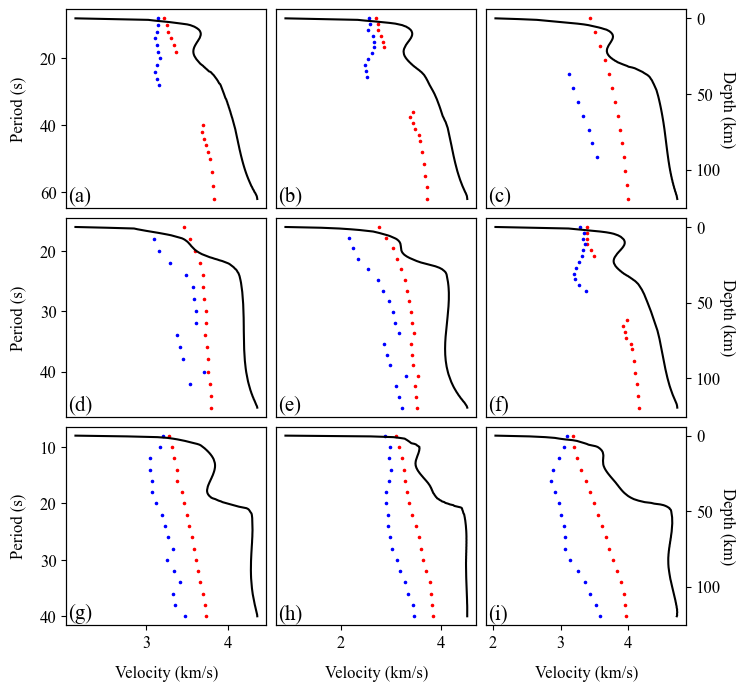

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

# Configure font and style for a clean, publication-quality aesthetic
rcParams.update({
    "font.size": 10,
    "font.family": "Times New Roman",
    "axes.labelsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "axes.titlesize": 12,
    "legend.fontsize": 8,
    "lines.markersize": 6
})

# Define the figure and grid layout
rows, cols = 3, 3
fig, ax = plt.subplots(rows, cols, figsize=(8, 8))
ranges = [(0, 25), (25, 30), (30, 35), (35, 45), (45, np.inf)]

# Nature-inspired color scheme
phase_vel_color = "r"  # soft blue
group_vel_color = "b"  # soft green
vs_color        = "k"  # gray
stations_ids = []
for i in range(rows):
    range_min, range_max = ranges[i]
    
    for j in range(cols):
        # Initialize num to ensure we sample until it falls within the range
        num = -1
        while not (range_min <= num < range_max):            
            temp = [8977,8947,8724,8157]
            idx = np.random.randint(0, real_dataset.__len__())
            if i == 0 and j == 0:
                idx = temp[0]
            elif i == 0 and j == 1:
                idx = temp[1]
            elif i == 1 and j == 0:
                idx = temp[2]
            elif i == 1 and j == 1:
                idx = temp[3]
            disp_data, _, vel_model, _ = real_dataset.__getitem__(idx)
            vel_model = vel_model[:, :240]
            disp_data = disp_data.cpu().detach().numpy()
            mask1 = disp_data[1, :] > 0
            mask2 = disp_data[2, :] > 0
            if (i == 0 and j == 0) or (i == 0 and j == 1) or (i == 1 and j == 0) or (i == 1 and j == 1):
                break
                
            num = np.sum(mask1) + np.sum(mask2)

        # Primary axis ax1 for dispersion data
        ax1 = ax[i][j]
        ax1.scatter(disp_data[1, mask1], disp_data[0, mask1], s=10, label="Phase-Vel", color=phase_vel_color, marker='.')
        ax1.scatter(disp_data[2, mask2], disp_data[0, mask2], s=10, label="Group-Vel", color=group_vel_color, marker='.')
        ax1.invert_yaxis()

        # ax1.text(0.05, 0.05, f"Sta: {idx}", transform=ax1.transAxes, fontsize=10, color="gray",
        #          verticalalignment="bottom", horizontalalignment="left")
        
        # Set y-axis label only on the first column and x-axis label only on the last row
        if j == 0:
            ax1.set_ylabel("Period (s)", fontsize=12, labelpad=10
                           , fontdict={"family":"Times New Roman",})
        if i == rows - 1:
            ax1.set_xlabel("Velocity (km/s)", fontsize=12, labelpad=10
                           , fontdict={"family":"Times New Roman",})

        # Remove ticks for non-edge subplots for cleaner look
        if j != 0:
            ax1.set_yticks([])
        if i != rows - 1:
            ax1.set_xticks([])
            
        # Secondary axis ax2 for velocity model
        ax2 = ax1.twinx()
        depth = vel_model[0, :]
        velocity = vel_model[1, :]
        ax2.plot(velocity, depth, color=vs_color, label="Vs")
        ax2.invert_yaxis()

        # Set right y-axis label only on the last column
        if j == cols - 1:
            ax2.set_ylabel("Depth (km)", rotation=270, fontsize=12, labelpad=10
                                       , fontdict={"family":"Times New Roman",})
            
        # Remove right y-axis ticks for non-edge subplots
        if j != cols - 1:
            ax2.set_yticks([])
        stations_ids.append(idx)

ax[0][0].text(0.01, 0.01, "(a)", fontsize=15, ha='left', va='bottom', transform=ax[0][0].transAxes)
ax[0][1].text(0.01, 0.01, "(b)", fontsize=15, ha='left', va='bottom', transform=ax[0][1].transAxes)
ax[0][2].text(0.01, 0.01, "(c)", fontsize=15, ha='left', va='bottom', transform=ax[0][2].transAxes)
ax[1][0].text(0.01, 0.01, "(d)", fontsize=15, ha='left', va='bottom', transform=ax[1][0].transAxes)
ax[1][1].text(0.01, 0.01, "(e)", fontsize=15, ha='left', va='bottom', transform=ax[1][1].transAxes)
ax[1][2].text(0.01, 0.01, "(f)", fontsize=15, ha='left', va='bottom', transform=ax[1][2].transAxes)
ax[2][0].text(0.01, 0.01, "(g)", fontsize=15, ha='left', va='bottom', transform=ax[2][0].transAxes)
ax[2][1].text(0.01, 0.01, "(h)", fontsize=15, ha='left', va='bottom', transform=ax[2][1].transAxes)
ax[2][2].text(0.01, 0.01, "(i)", fontsize=15, ha='left', va='bottom', transform=ax[2][2].transAxes)

# Adjust subplot spacing and display the plot
plt.subplots_adjust(hspace=0.05, wspace=0.05)
plt.savefig(os.path.join(plot_base_path,"CSRM-Data-Distribution.png"),bbox_inches="tight",dpi=300)
plt.show()

## Zero-shot and Few-shot Learning

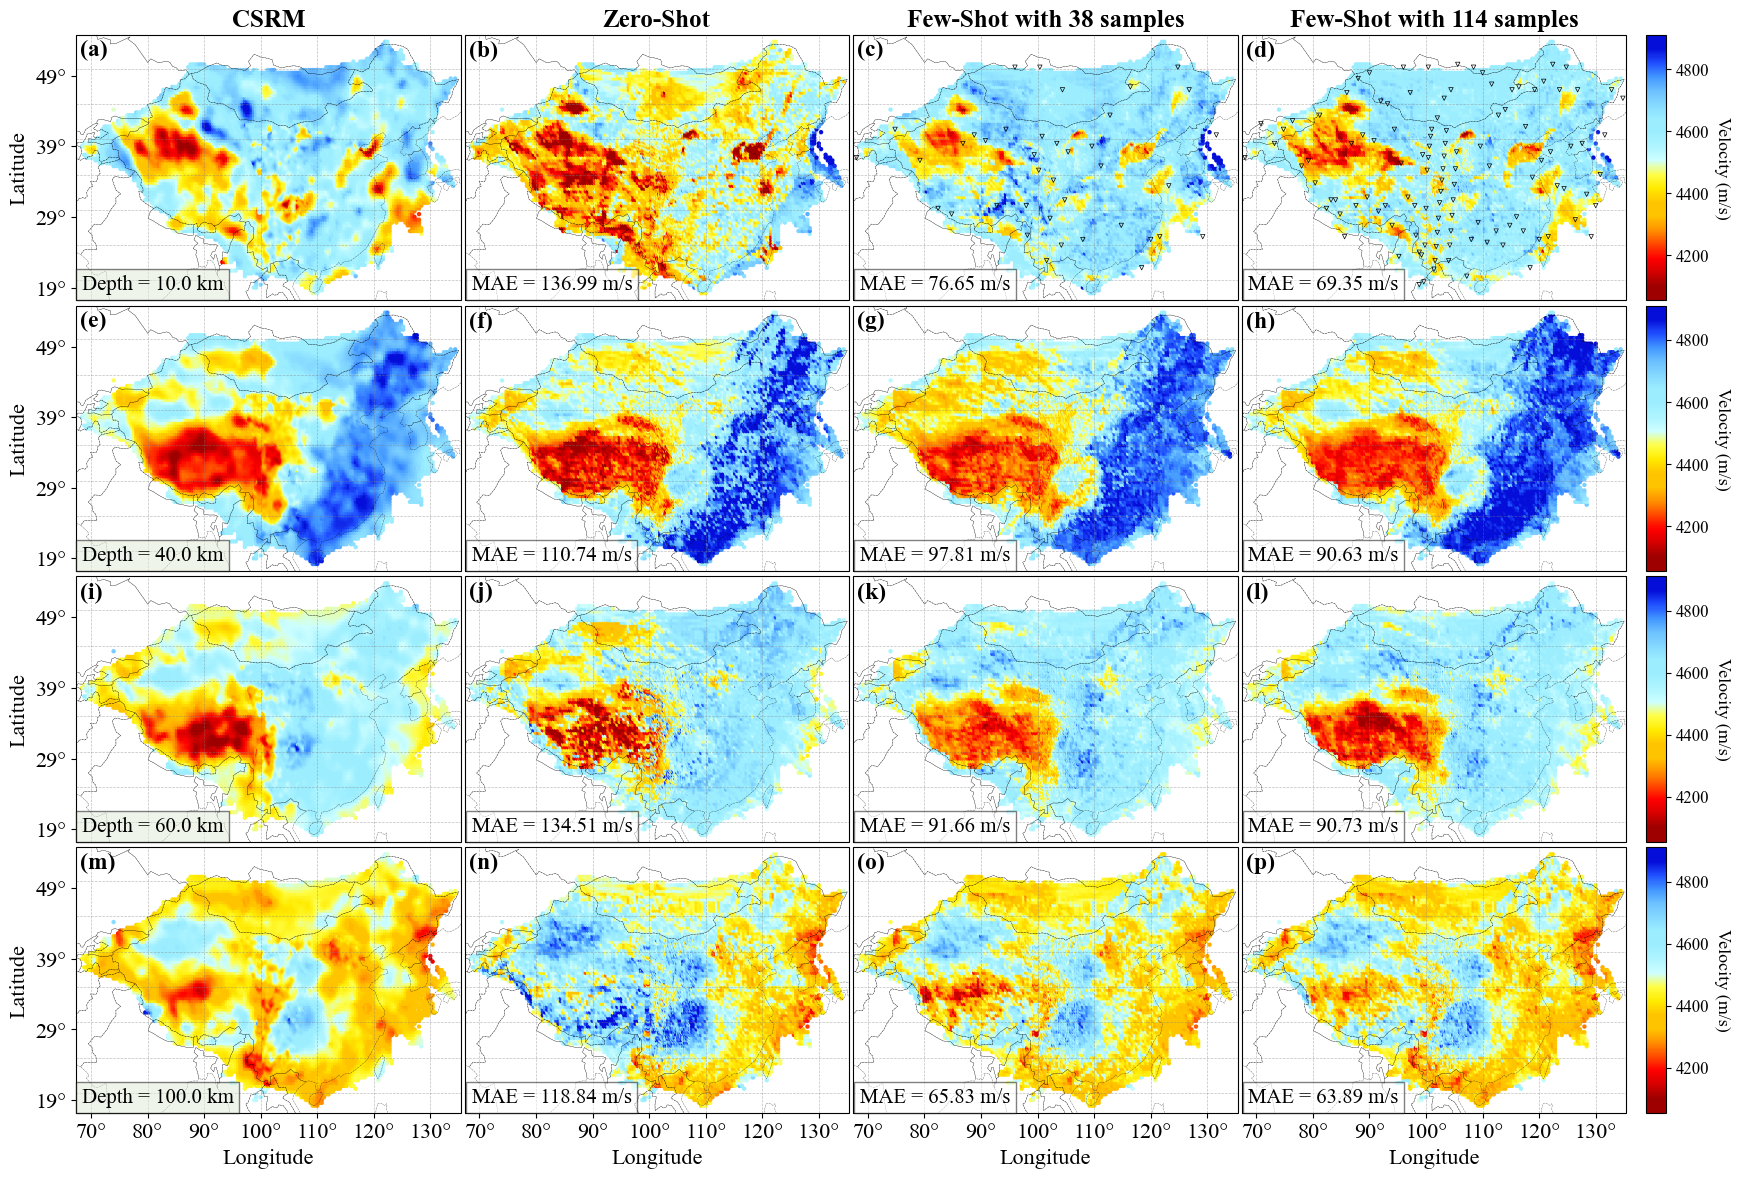

In [13]:
import cartopy.crs as ccrs
from cartopy.feature import ShapelyFeature
from cartopy.io.shapereader import Reader
import matplotlib as mpl

# Set font style and size
plt.rcParams['font.family'] = 'Times New Roman'  # Font family
plt.rcParams['font.size'] = 12  # Font size

# Load custom shapefile for coastlines
custom_shapefile_path ="DispFormer/plot_source/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shx"
coastline_feature = ShapelyFeature(Reader(custom_shapefile_path).geometries(), ccrs.PlateCarree())

def add_right_cax(ax, pad, width):
    axpos = ax.get_position()
    # Ensure the colorbar height matches the height of axs[row][3]
    caxpos = mpl.transforms.Bbox.from_extents(
        axpos.x1 + pad,
        axpos.y0,
        axpos.x1 + pad + width,
        axpos.y1
    )
    cax = ax.figure.add_axes(caxpos)
    return cax

def plot_rows(axs, row, depth_idx, last_row=False):
    # Determine color limits for the first two scatter plots
    vmin = np.min(target_vs[:, 1, depth_idx])*1000
    vmax = np.max(target_vs[:, 1, depth_idx])*1000
    ########################################################################
    # Scatter plot for target values
    scatter0 = axs[row][0].scatter(all_disp_loc[:, 0], all_disp_loc[:, 1], c=target_vs[:, 1, depth_idx]*1000, cmap=cmap, s=10, vmin=vmin, vmax=vmax, edgecolor='None', alpha=1)
    if last_row:
        axs[row][0].set_xlabel("Longitude", fontsize=16)
    else:
        axs[row][0].set_xticks([])
    axs[row][0].set_ylabel("Latitude", fontsize=16)
    axs[row][0].annotate(f"Depth = {depth_idx*0.5:.1f} km",
                            xy=(all_disp_loc[:, 0].min(), all_disp_loc[:, 1].min() + 0.5),
                            xycoords='data', fontsize=15, color='black',
                            bbox=dict(facecolor='#DFEBD5', alpha=0.5, edgecolor='black'))
    ########################################################################
    # Scatter plot for target values
    scatter1 = axs[row][1].scatter(all_disp_loc[:, 0], all_disp_loc[:, 1], c= inv_vs_zeroshot[:, depth_idx]*1000, cmap=cmap, s=10, vmin=vmin, vmax=vmax, edgecolor='None', alpha=1)
    if last_row:
        axs[row][1].set_xlabel("Longitude", fontsize=16)
    else:
        axs[row][1].set_xticks([])
    axs[row][1].set_yticks([])
    # Compute MAE and annotate
    
    mae = np.mean(np.abs(target_vs[:, 1, depth_idx] - inv_vs_zeroshot[:, depth_idx])) * 1000  # Convert to km
    axs[row][1].annotate(f"MAE = {mae:.2f} m/s",
                            xy=(all_disp_loc[:, 0].min()+0.2, all_disp_loc[:, 1].min() + 0.5),
                            xycoords='data', fontsize=15, color='black',
                            bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'))

    ########################################################################
    # Scatter plot for inverted values
    scatter2 = axs[row][2].scatter(all_disp_loc[:, 0], all_disp_loc[:, 1], c=inv_vs_fewshot300[:, depth_idx]*1000, cmap=cmap, s=10, vmin=vmin, vmax=vmax, edgecolor='None', alpha=1)
    if last_row:
        axs[row][2].set_xlabel("Longitude", fontsize=16)
    else:
        axs[row][2].set_xticks([])
    axs[row][2].set_yticks([])
    # Compute MAE and annotate
    mae = np.mean(np.abs(target_vs[:, 1, depth_idx] - inv_vs_fewshot300[:, depth_idx])) * 1000  # Convert to km
    axs[row][2].annotate(f"MAE = {mae:.2f} m/s",
                            xy=(all_disp_loc[:, 0].min()+0.2, all_disp_loc[:, 1].min() + 0.5),
                            xycoords='data', fontsize=15, color='black',
                            bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'))

    ########################################################################
    # Scatter plot for inverted values
    scatter3 = axs[row][3].scatter(all_disp_loc[:, 0], all_disp_loc[:, 1], c=inv_vs_fewshot100[:, depth_idx]*1000, cmap=cmap, s=10, vmin=vmin, vmax=vmax, edgecolor='None', alpha=1)
    if last_row:
        axs[row][3].set_xlabel("Longitude", fontsize=16)
        axs[row][3].tick_params(labelsize=16)
    else:
        axs[row][3].set_xticks([])
    axs[row][3].set_yticks([])

    # Compute MAE and annotate
    mae = np.mean(np.abs(target_vs[:, 1, depth_idx] - inv_vs_fewshot100[:, depth_idx])) * 1000  # Convert to km
    axs[row][3].annotate(f"MAE = {mae:.2f} m/s",
                            xy=(all_disp_loc[:, 0].min()+0.2, all_disp_loc[:, 1].min() + 0.5),
                            xycoords='data', fontsize=15, color='black',
                            bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'))

    # ########################################################################
    # Add coastline feature
    for ax in axs[row]:
        ax.add_feature(coastline_feature, edgecolor='black', facecolor='None', linewidth=0.2, linestyle='-.')
    
    # automatic set the aspect
    for ax in axs[row]:
        ax.set_aspect('auto')
    
    # set the Longitude/latitude gridline
    for ax in axs[row]:
        gl0                 = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
        gl0.top_labels      = False # Disable top labels
        gl0.right_labels    = False  # Disable right labels
        gl0.left_labels     = False
        gl0.bottom_labels   = False
        gl0.xlabel_style    = {'size': 8, 'color': 'black'}  # Customize label style
        gl0.ylabel_style    = {'size': 8, 'color': 'black'}  # Customize label style

    # Set extent for automatic ticks
    extent = [all_disp_loc[:, 0].min() - 1, all_disp_loc[:, 0].max() + 1,
              all_disp_loc[:, 1].min() - 1, all_disp_loc[:, 1].max() + 1]
    for ax in axs[row]:
        ax.set_extent(extent, crs=ccrs.PlateCarree())
        ax.tick_params(labelsize=16)

    # Set latitude and Longitude ticks
    x_ticks_begin_shift = 2
    y_ticks_begin_shift = 1
    x_ticks_interval    = 10
    y_ticks_interval    = 10
    axs[row][0].set_yticks(np.arange(np.floor(all_disp_loc[:, 1].min()) + y_ticks_begin_shift,
                                      np.ceil(all_disp_loc[:, 1].max()) + 1, y_ticks_interval),
                                    crs=ccrs.PlateCarree())
    axs[row][0].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0f}°'))
    if last_row:
        for ax in axs[row]:
            ax.set_xticks(np.arange(np.floor(all_disp_loc[:, 0].min()) + x_ticks_begin_shift,
                                    np.ceil(all_disp_loc[:, 0].max()), x_ticks_interval),
                                  crs=ccrs.PlateCarree())
            ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}°'))
    
    #####################################################################
    # Add vertical colorbar for the scatter plot on axs[row][0]
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    sm   = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # Required for creating colorbar
    return sm


# Create subplots with PlateCarree projection
fig, axs = plt.subplots(4, 4, figsize=(20, 14), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot for different depths
plot_rows(axs, 0, 20)
axs[0][2].scatter(train_disp_loc[:, 0][::300], train_disp_loc[:, 1][::300], facecolor='None', edgecolor='k',linewidth=0.5, marker='v', s=10)
axs[0][3].scatter(train_disp_loc[:, 0][::100], train_disp_loc[:, 1][::100], facecolor='None', edgecolor='k',linewidth=0.5, marker='v', s=10)
plot_rows(axs, 1, 80)
plot_rows(axs, 2, 120)
sm = plot_rows(axs, 3, 200, last_row=True)

# Set titles for each column
axs[0][0].set_title( 'CSRM', fontsize=18, fontweight='bold')
axs[0][1].set_title( 'Zero-Shot', fontsize=18, fontweight='bold')
axs[0][2].set_title(f'Few-Shot with {train_dataset.__len__()//300:.0f} samples', fontsize=18, fontweight='bold')
axs[0][3].set_title(f'Few-Shot with {train_dataset.__len__()//100:.0f} samples', fontsize=18, fontweight='bold')

# Adjust layout
plt.subplots_adjust(hspace=0.02, wspace=0.01)

for row in range(4):
    cax = add_right_cax(axs[row][3], pad=0.01, width=0.01)
    cbar = plt.colorbar(sm, cax=cax)
    cbar.set_label('Velocity (m/s)', fontsize=13, rotation=270, labelpad = 15)

labels_title = ["(a)","(b)","(c)","(d)",
                "(e)","(f)","(g)","(h)",
                "(i)","(j)","(k)","(l)",
                "(m)","(n)","(o)","(p)"]
for i in range(4):
    for j in range(4):
        axs[i][j].text(0.01, 0.98, labels_title[i*4+j], transform=axs[i][j].transAxes, fontsize=17, fontweight='bold', va='top', ha='left', color='black')

    
plt.savefig(os.path.join(plot_base_path,"CSRM-Inverted-Results-cmp-Slice.png"),bbox_inches='tight',dpi=300)
plt.show()

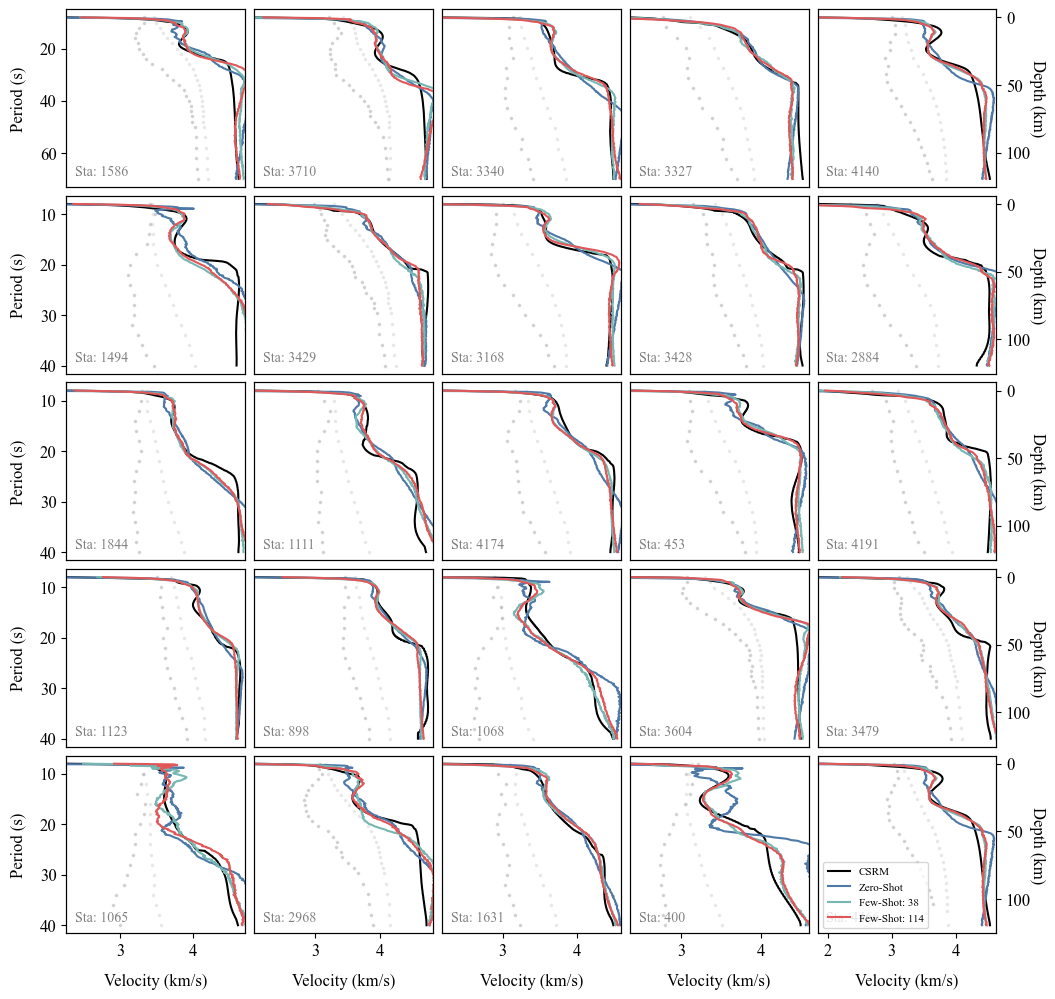

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

# Configure Nature-inspired styling for clarity and subtlety
rcParams.update({
    "font.size": 10,
    "font.family": "Times New Roman",
    "axes.labelsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "axes.titlesize": 12,
    "legend.fontsize": 8,
    "lines.markersize": 6
})

# Define figure layout
rows, cols = 5, 5
fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
ranges = [(0, 25), (25, 30), (30, 35), (35, 45), (45, np.inf)]

# Nature-inspired colors for velocity models and subdued colors for period data
phase_vel_color     = "#D3D3D3"    # light gray for phase velocity
group_vel_color     = "#A9A9A9"    # darker gray for group velocity
csrm_vs_color       = "k"        # soft blue for CSRM model
zeroshot_vs_color   = "#4E79A7"  # coral red for Zero-Shot model
fewshot300_vs_color = "#76B7B2"  # teal for Few-Shot with 300 samples
fewshot100_vs_color = "#E15759"  # green for Few-Shot with 100 samples

for i in range(rows):
    range_min, range_max = ranges[i]
    for j in range(cols):
        # Ensure data samples are within range for proper visualization
        idx = np.random.randint(0,5000)
        disp_data, _, vel_model, _ = real_dataset.__getitem__(idx)
        vel_model = vel_model[:, :240]
        disp_data = disp_data.cpu().detach().numpy()
        mask1 = disp_data[1, :] > 0
        mask2 = disp_data[2, :] > 0

        # Primary axis for period data, de-emphasized in gray tones
        ax1 = ax[i][j]
        ax1.scatter(disp_data[1, mask1], disp_data[0, mask1], s=10,
                    color=phase_vel_color, alpha=0.4, marker='.')
        ax1.scatter(disp_data[2, mask2], disp_data[0, mask2], s=10,
                    color=group_vel_color, alpha=0.4, marker='.')
        ax1.invert_yaxis()

        # Station label in bottom-left corner of each plot
        ax1.text(0.05, 0.05, f"Sta: {idx}", transform=ax1.transAxes, fontsize=10, color="gray",
                 verticalalignment="bottom", horizontalalignment="left")
        
        # Axis labels for outermost plots only
        if j == 0:
            ax1.set_ylabel("Period (s)", fontsize=12, labelpad=10, fontdict={"family": "Times New Roman"})
        if i == rows - 1:
            ax1.set_xlabel("Velocity (km/s)", fontsize=12, labelpad=10, fontdict={"family": "Times New Roman"})

        # Clear ticks on inner plots for cleanliness
        if j != 0:
            ax1.set_yticks([])
        if i != rows - 1:
            ax1.set_xticks([])
            
        # Secondary axis for velocity model
        ax2 = ax1.twinx()
        depth = vel_model[0, :]
        velocity = vel_model[1, :]
        ax2.plot(velocity, depth, color=csrm_vs_color, label="CSRM")
        ax2.plot(inv_vs_zeroshot[idx, :len(depth)], depth, color=zeroshot_vs_color    , label="Zero-Shot")
        ax2.plot(inv_vs_fewshot300[idx, :len(depth)], depth, color=fewshot300_vs_color, label=f"Few-Shot: {train_dataset.__len__()//300:.0f}")
        ax2.plot(inv_vs_fewshot100[idx, :len(depth)], depth, color=fewshot100_vs_color, label=f"Few-Shot: {train_dataset.__len__()//100:.0f}")
        ax2.invert_yaxis()

        # Label depth only for the last column to avoid overcrowding
        if j == cols - 1:
            ax2.set_ylabel("Depth (km)", rotation=270, fontsize=12, labelpad=10,
                           fontdict={"family": "Times New Roman"})
            
        # Clear right y-axis ticks for inner plots
        if j != cols - 1:
            ax2.set_yticks([])

        if i == rows-1 and j == cols-1:
            ax2.legend()
        
        ax2.set_xlim(velocity.min(),velocity.max()+0.1)
# Adjust layout spacing
plt.subplots_adjust(hspace=0.05, wspace=0.05)
plt.savefig(os.path.join(plot_base_path,"CSRM-Inverted-Results-cmp-Single.png"),bbox_inches='tight',dpi=300)
plt.show()

## Statistic Results

In [15]:
ref_disp_temp           = np.load(os.path.join("Script/ModelDesign/test-few-shot/datasets","ref_disp.npz"))["data"]
zero_shot_disp_temp     = np.load(os.path.join("Script/ModelDesign/test-few-shot/datasets","inv_disp_zeroshot.npz"))["data"]
fewshot100_disp_temp    = np.load(os.path.join("Script/ModelDesign/test-few-shot/datasets","inv_disp_finetune_sparse100.npz"))["data"]

In [16]:
obs_period = inputs_disp[0,0,:]
syn_period = ref_disp_temp[0,:,0]

# Function to compute Mean Absolute Error (MAE)
def MAE_np_layer(output, target):
    # Apply mask to keep only positive elements in both output and target
    mask = (output > 0) & (target > 0)
    
    # Use np.where to set masked elements to zero while keeping the original shape
    output = np.where(mask, output, 0)
    target = np.where(mask, target, 0)
    
    # Calculate MAE along the specified axis while ignoring zero values
    diff = np.abs(output - target)
    masked_sum = np.sum(diff, axis=1)
    mask_sum = np.sum(mask, axis=1)
    
    # Avoid division by zero by setting mask_sum=1 for rows where mask_sum=0
    mask_sum[mask_sum == 0] = 1
    mae = masked_sum / mask_sum * 1000

    return mae

# Calculate residuals (MAE) for both phase and group dispersion curves
ref_phase_residual        =  MAE_np_layer(ref_disp_temp[:, :, 1]        , inputs_disp[:, 1, :])
ref_group_residual        =  MAE_np_layer(ref_disp_temp[:, :, 2]        , inputs_disp[:, 2, :])
zeroshot_phase_residual   =  MAE_np_layer(zero_shot_disp_temp[:, :, 1]  , inputs_disp[:, 1, :])
zeroshot_group_residual   =  MAE_np_layer(zero_shot_disp_temp[:, :, 2]  , inputs_disp[:, 2, :])
fewshot100_phase_residual =  MAE_np_layer(fewshot100_disp_temp[:, :, 1] , inputs_disp[:, 1, :])
fewshot100_group_residual =  MAE_np_layer(fewshot100_disp_temp[:, :, 2] , inputs_disp[:, 2, :])

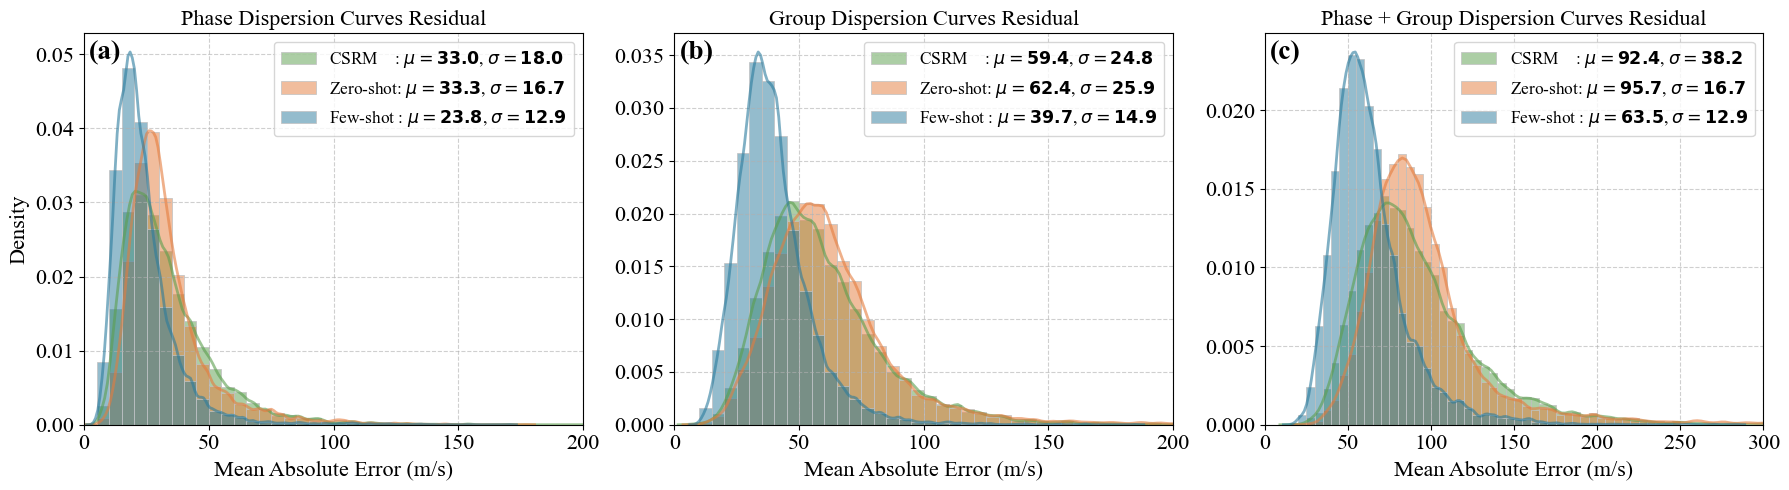

In [17]:
##########################################################################################
import matplotlib.pyplot as plt
import seaborn as sns

# Create figures
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Define the range and bins for the histograms
min_val = 0
max_val = 250
bin_width = 5
bins = np.arange(min_val, max_val + bin_width, bin_width)  # Define bins with fixed width

# Calculate the mean of each residual array for display in the legend
mean_ref_phase        = np.mean(ref_phase_residual)
mean_zeroshot_phase   = np.mean(zeroshot_phase_residual)
mean_fewshot100_phase = np.mean(fewshot100_phase_residual)

mean_ref_group        = np.mean(ref_group_residual)
mean_zeroshot_group   = np.mean(zeroshot_group_residual)
mean_fewshot100_group = np.mean(fewshot100_group_residual)

mean_ref_total        = np.mean(ref_phase_residual + ref_group_residual)
mean_zeroshot_total   = np.mean(mean_zeroshot_phase + mean_zeroshot_group)
mean_fewshot100_total = np.mean(mean_fewshot100_phase + mean_fewshot100_group)


std_ref_phase = np.std(ref_phase_residual)
std_zeroshot_phase = np.std(zeroshot_phase_residual)
std_fewshot100_phase = np.std(fewshot100_phase_residual)

std_ref_group = np.std(ref_group_residual)
std_zeroshot_group = np.std(zeroshot_group_residual)
std_fewshot100_group = np.std(fewshot100_group_residual)

std_ref_total        = np.std(ref_phase_residual + ref_group_residual)
std_zeroshot_total   = np.std(zeroshot_phase_residual + mean_zeroshot_group)
std_fewshot100_total = np.std(fewshot100_phase_residual + mean_fewshot100_group)


color1 = '#2A7B9D'
color2 = '#E57C3D'
color3 = '#5B9E4D'
color4 = '#C2C2C2'

# Function to plot residuals
def plot_residuals(ax, data1, data2, data3, label1, label2, label3, 
                   mean1, mean2, mean3,
                   std1, std2, std3,
                   title, xlim):
    # Using LaTeX for bold mean representation
    sns.histplot(data1, bins=bins, edgecolor=color4, alpha=0.5, kde=False, 
                 ax=ax, stat='density', label=f'{label1}: $\\mu=\\mathbf{{{mean1:.1f}}}$, $\\sigma=\\mathbf{{{std1:.1f}}}$', color=color3)
    sns.histplot(data2, bins=bins, edgecolor=color4, alpha=0.5, kde=False, 
                 ax=ax, stat='density', label=f'{label2}: $\\mu=\\mathbf{{{mean2:.1f}}}$, $\\sigma=\\mathbf{{{std2:.1f}}}$', color=color2)
    sns.histplot(data3, bins=bins, edgecolor=color4, alpha=0.5, kde=False, 
                 ax=ax, stat='density', label=f'{label3}: $\\mu=\\mathbf{{{mean3:.1f}}}$, $\\sigma=\\mathbf{{{std3:.1f}}}$', color=color1)

    # Add KDE line
    sns.kdeplot(data1, color=color3, linewidth=2, alpha=0.6, ax=ax, bw_adjust=0.5)
    sns.kdeplot(data2, color=color2, linewidth=2, alpha=0.6, ax=ax, bw_adjust=0.5)
    sns.kdeplot(data3, color=color1, linewidth=2, alpha=0.6, ax=ax, bw_adjust=0.5)

    ax.set_title(title, fontsize=16)  # Set title font size to 14
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.set_xlim(0, xlim)
    ax.legend(fontsize=12.5)  # Set legend font size to 14

# Phase Dispersion Curves Residual
plot_residuals(axs[0], 
               ref_phase_residual, zeroshot_phase_residual,fewshot100_phase_residual,
               'CSRM \t', f'Zero-shot',f'Few-shot ',
               mean_ref_phase, mean_zeroshot_phase, mean_fewshot100_phase,
               std_ref_phase,std_zeroshot_phase,std_fewshot100_phase,
               "Phase Dispersion Curves Residual", 200)

# Group Dispersion Curves Residual
plot_residuals(axs[1], 
               ref_group_residual, zeroshot_group_residual,fewshot100_group_residual,
               'CSRM \t', f'Zero-shot',f'Few-shot ',
               mean_ref_group, mean_zeroshot_group, mean_fewshot100_group,
               std_ref_group,std_zeroshot_group,std_fewshot100_group,
               "Group Dispersion Curves Residual", 200)

# Phase + Group Dispersion Curves Residual
plot_residuals(axs[2], 
               ref_phase_residual + ref_group_residual, 
               zeroshot_phase_residual + zeroshot_group_residual, 
               fewshot100_phase_residual + fewshot100_group_residual,
               'CSRM \t', f'Zero-shot',f'Few-shot ',
               mean_ref_total, mean_zeroshot_total, mean_fewshot100_total,
               std_ref_total, std_zeroshot_total, std_fewshot100_total,
               "Phase + Group Dispersion Curves Residual", 300)

# Set y-labels and x-labels
axs[0].set_ylabel("Density", fontsize=16)  # Set y-label font size to 14
axs[0].set_xlabel("Mean Absolute Error (m/s)", fontsize=16)  # Set x-label font size to 14

# Hide y-labels for second and third subplots
axs[1].set_ylabel("")  
axs[2].set_ylabel("")  

# Set x-label for second and third subplots
axs[1].set_xlabel("Mean Absolute Error (m/s)", fontsize=16)
axs[2].set_xlabel("Mean Absolute Error (m/s)", fontsize=16)

axs[0].tick_params(labelsize=16)
axs[1].tick_params(labelsize=16)
axs[2].tick_params(labelsize=16)

# Add label text in the top-left corner of each subplot
axs[0].text(0.01, 0.98, "(a)", transform=axs[0].transAxes, fontsize=20, fontweight='bold', va='top', ha='left', color='black')
axs[1].text(0.01, 0.98, "(b)", transform=axs[1].transAxes, fontsize=20, fontweight='bold', va='top', ha='left', color='black')
axs[2].text(0.01, 0.98, "(c)", transform=axs[2].transAxes, fontsize=20, fontweight='bold', va='top', ha='left', color='black')


# Adjust layout for better spacing
plt.tight_layout()
plt.savefig(os.path.join(plot_base_path,"CSRM-Inverted-dataResidual-Statistic.png"),bbox_inches='tight',dpi=300)
plt.show()